In [ ]:
# merge_consec_bookings(initial/BookingMultiDestinations) -> 'processed/my-df-mdt'

In [ ]:
from Modules.data_processing import set_rewards_toppop


set_rewards_toppop('data/processed/my-df-mdt.csv', save_name='data/processed/my-pop-mdt-buy.csv')
set_rewards_toppop('data/processed/test-my-df-mdt.csv', save_name='data/processed/test-my-pop-mdt-buy.csv', pop_ratio=0.05)

,utrip_id,checkin,checkout,city_id,is_buy
0,1000066_2,2016-07-21,2016-07-23,56430,0
1,1000066_2,2016-07-23,2016-07-25,41971,1
2,1000066_2,2016-07-25,2016-07-28,5797,1
3,1000270_1,2016-02-08,2016-02-09,50075,1
4,1000270_1,2016-02-09,2016-02-10,29207,0
...,...,...,...,...,...
287115,999911_1,2016-10-03,2016-10-05,23921,1
287116,999911_1,2016-10-05,2016-10-07,21730,1
287117,999991_3,2016-08-15,2016-08-17,29770,1
287118,999991_3,2016-08-18,2016-08-19,36170,1


In [ ]:
from Modules.data_processing import set_rewards_most_time


set_rewards_most_time('data/processed/my-df-mdt.csv', save_name='data/processed/my-time-mdt-buy.csv')
set_rewards_most_time('data/processed/test-my-df-mdt.csv', save_name='data/processed/test-my-time-mdt-buy.csv')

,utrip_id,checkin,checkout,city_id,time_at,is_buy
0,1000066_2,2016-07-21,2016-07-23,56430,2,0
1,1000066_2,2016-07-23,2016-07-25,41971,2,0
2,1000066_2,2016-07-25,2016-07-28,5797,3,1
3,1000270_1,2016-02-08,2016-02-09,50075,1,0
4,1000270_1,2016-02-09,2016-02-10,29207,1,0
...,...,...,...,...,...,...
287115,999911_1,2016-10-03,2016-10-05,23921,2,1
287116,999911_1,2016-10-05,2016-10-07,21730,2,0
287117,999991_3,2016-08-15,2016-08-17,29770,2,1
287118,999991_3,2016-08-18,2016-08-19,36170,1,0


In [ ]:
from Modules.data_processing import set_rewards_consecutive


set_rewards_consecutive('data/processed/my-df-mdt.csv', save_name='data/processed/my-consec-mdt-buy.csv')
set_rewards_consecutive('data/processed/test-my-df-mdt.csv', save_name='data/processed/test-my-consec-mdt-buy.csv')

,utrip_id,checkin,checkout,city_id,next_city_id,is_buy
0,1000066_2,2016-07-21,2016-07-23,56430,41971.0,0
1,1000066_2,2016-07-23,2016-07-25,41971,5797.0,1
2,1000066_2,2016-07-25,2016-07-28,5797,41971.0,1
3,1000270_1,2016-02-08,2016-02-09,50075,41685.0,0
4,1000270_1,2016-02-09,2016-02-10,29207,17128.0,0
...,...,...,...,...,...,...
287115,999911_1,2016-10-03,2016-10-05,23921,8750.0,0
287116,999911_1,2016-10-05,2016-10-07,21730,5325.0,0
287117,999991_3,2016-08-15,2016-08-17,29770,55196.0,0
287118,999991_3,2016-08-18,2016-08-19,36170,19444.0,0


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import tensorflow as tf
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dat = '/content/drive/MyDrive/COURSEW/BOOKING/data/processed/'  # for collab
# dat = 'data/processed/'

In [20]:
ground_truth = pd.read_csv('/content/drive/MyDrive/COURSEW/BOOKING/data/initial/ground_truth.csv').drop(['id'], axis=1)
ground_truth_t = ground_truth.copy()
ground_truth_p = ground_truth.copy()
ground_truth_c = ground_truth.copy()

In [5]:
from Modules.data_processing import preprocess_booking, get_statistics, create_pop_dict, shorten_sessions

Processing for the "most time at" reward

In [6]:
df_train_t, itm2idx_t, idx2itm = preprocess_booking(dat + 'my-time-mdt-buy.csv')
df_test_t, _, _  = preprocess_booking(dat + 'test-my-time-mdt-buy.csv', itm2idx=itm2idx_t)


sh_df_train_t, new_itm2idx_t = shorten_sessions(df_train_t, n_sessions=50000)
sh_df_test_t = df_test_t.loc[df_test_t['item_id'].isin(new_itm2idx_t.keys())]
sh_df_test_t.loc[:, 'item_id'] = sh_df_test_t['item_id'].map(new_itm2idx_t)
sh_df_test_t['item_id'].isna().sum()

unique: 22872 min: 0 max: 22871


0

In [21]:
ground_truth_t.loc[:, 'city_id'] = ground_truth_t['city_id'].map(itm2idx_t)
sh_ground_truth_t = ground_truth_t.loc[ground_truth_t['city_id'].isin(new_itm2idx_t.keys())]
sh_ground_truth_t.loc[:, 'city_id'] = sh_ground_truth_t['city_id'].map(new_itm2idx_t)

Processing for the "top popular" reward

In [8]:
df_train_p, itm2idx_p, _ = preprocess_booking(dat + 'my-pop-mdt-buy.csv', col_n=5)
df_test_p, _, _  = preprocess_booking(dat + 'test-my-pop-mdt-buy.csv', itm2idx=itm2idx_p, col_n=5)


sh_df_train_p, new_itm2idx_p = shorten_sessions(df_train_t, n_sessions=50000)
sh_df_test_p = df_test_p.loc[df_test_p['item_id'].isin(new_itm2idx_p.keys())]
sh_df_test_p.loc[:, 'item_id'] = sh_df_test_p['item_id'].map(new_itm2idx_p)
sh_df_test_p['item_id'].isna().sum()

unique: 22699 min: 0 max: 22698


0

In [22]:
ground_truth_p.loc[:, 'city_id'] = ground_truth_p['city_id'].map(itm2idx_p)
sh_ground_truth_p = ground_truth_p.loc[ground_truth_p['city_id'].isin(new_itm2idx_p.keys())]
sh_ground_truth_p.loc[:, 'city_id'] = sh_ground_truth_p['city_id'].map(new_itm2idx_p)

Processing for the popular "consecutive cities" reward

In [10]:
df_train_c, itm2idx_c, _ = preprocess_booking(dat + 'my-consec-mdt-buy.csv')
df_test_c, _, _  = preprocess_booking(dat + 'test-my-consec-mdt-buy.csv', itm2idx=itm2idx_c)


sh_df_train_c, new_itm2idx_c = shorten_sessions(df_train_c, n_sessions=50000)
sh_df_test_c = df_test_c.loc[df_test_c['item_id'].isin(new_itm2idx_c.keys())]
sh_df_test_c.loc[:, 'item_id'] = sh_df_test_c['item_id'].map(new_itm2idx_c)
sh_df_test_c['item_id'].isna().sum()

unique: 22782 min: 0 max: 22781


0

In [23]:
ground_truth_c.loc[:, 'city_id'] = ground_truth_c['city_id'].map(itm2idx_c)
sh_ground_truth_c = ground_truth_c.loc[ground_truth_c['city_id'].isin(new_itm2idx_c.keys())]
sh_ground_truth_c.loc[:, 'city_id'] = sh_ground_truth_c['city_id'].map(new_itm2idx_c)

In [12]:
# df_t = pd.concat([df_train_t, df_test_t], ignore_index=True).sort_values(by=['session_id', 'timestamp'])
sh_df_t = pd.concat([sh_df_train_t, sh_df_test_t], ignore_index=True).sort_values(by=['session_id', 'timestamp'])
# df_p = pd.concat([df_train_p, df_test_p], ignore_index=True).sort_values(by=['session_id', 'timestamp'])
sh_df_p = pd.concat([sh_df_train_p, sh_df_test_p], ignore_index=True).sort_values(by=['session_id', 'timestamp'])
# df_c = pd.concat([df_train_c, df_test_c], ignore_index=True).sort_values(by=['session_id', 'timestamp'])
sh_df_c = pd.concat([sh_df_train_c, sh_df_test_c], ignore_index=True).sort_values(by=['session_id', 'timestamp'])

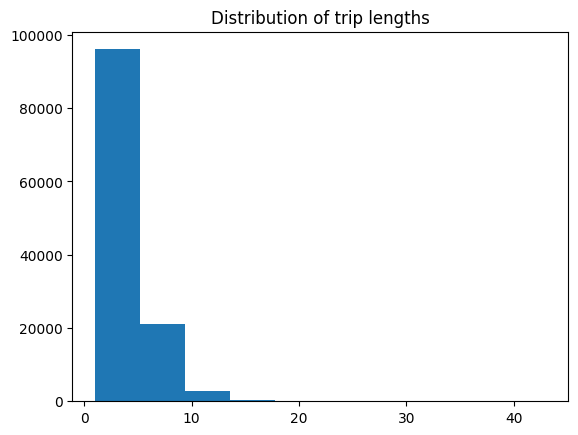

In [13]:
import matplotlib.pyplot as plt


plt.hist(sh_df_t.session_id.value_counts())
plt.title('Distribution of trip lengths')
plt.show()

A good value for history length according to the histogram is 7

In [19]:
# replay_buf_t, data_stats_t = get_statistics(df_t, df_train_t, length=7)
# replay_buf_p, data_stats_p = get_statistics(df_p, df_train_p, length=7)
# replay_buf_c, data_stats_c = get_statistics(df_c, df_train_c, length=7)

In [14]:
sh_replay_buf_t, sh_data_stats_t = get_statistics(sh_df_t, sh_df_train_t, length=7)
sh_replay_buf_p, sh_data_stats_p = get_statistics(sh_df_p, sh_df_train_p, length=7)
sh_replay_buf_c, sh_data_stats_c = get_statistics(sh_df_c, sh_df_train_c, length=7)

In [20]:
# %pip install trfl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 3.5 MB/s eta 0:00:00


In [15]:
from Modules.training import train_no_eval, predict_booking_batched

In [17]:
def evaluate_accuracy_at(submission,ground_truth, at=4):
    '''checks if the true city is within the four recommended cities'''
    data = submission.merge(ground_truth,on='utrip_id')

    if at==4:
      hits = ((data['city_id']==data['city_id_1'])|(data['city_id']==data['city_id_2'])|
        (data['city_id']==data['city_id_3'])|(data['city_id']==data['city_id_4']))*1
    elif at==10:
      hits = ((data['city_id']==data['city_id_1'])|(data['city_id']==data['city_id_2'])|
        (data['city_id']==data['city_id_3'])|(data['city_id']==data['city_id_4'])|
        (data['city_id']==data['city_id_5'])|(data['city_id']==data['city_id_6'])|
        (data['city_id']==data['city_id_7'])|(data['city_id']==data['city_id_8'])|
        (data['city_id']==data['city_id_9'])|(data['city_id']==data['city_id_10']))*1
    return hits.mean()

### Most time reward

In [18]:
arg_dict = {'r_click' : 0.7,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.0015,
            'epoch' : 30,
            'batch_size' : 512,
            'neg' : 10,
            'discount' : 0.5,
            'smooth' : 0.0,
            'clip' : 0.0
            }
losses_t = []
SNQN_t, sess_t  = train_no_eval(sh_data_stats_t, sh_replay_buf_t, arg_dict=arg_dict, losses=losses_t, configuration='SNQN')

Instructions for updating:
non-resource variables are not supported in the long term
/content/Modules/Network.py:86: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/content/Modules/SASRec.py:131: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/content/Modules/SASRec.py:132: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/content/Modules/SASRec.py:133: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  V = tf.compat.v1.layers.dense(keys, num_units, 

$$$$$$$ STARTING EPOCH 0 $$$$$$$
the loss in 50th batch / 485 is: 15.692991
the loss in 100th batch / 485 is: 10.956091
the loss in 150th batch / 485 is: 9.692581
the loss in 200th batch / 485 is: 9.696996
the loss in 250th batch / 485 is: 9.629321
the loss in 300th batch / 485 is: 9.663274
the loss in 350th batch / 485 is: 9.450041
the loss in 400th batch / 485 is: 9.426473
the loss in 450th batch / 485 is: 9.357160
$$$$$$$ STARTING EPOCH 1 $$$$$$$
the loss in 500th batch / 485 is: 8.558138
the loss in 550th batch / 485 is: 8.129884
the loss in 600th batch / 485 is: 7.824142
the loss in 650th batch / 485 is: 7.662718
the loss in 700th batch / 485 is: 7.184328
the loss in 750th batch / 485 is: 7.226996
the loss in 800th batch / 485 is: 6.918771
the loss in 850th batch / 485 is: 6.632276
the loss in 900th batch / 485 is: 6.547918
the loss in 950th batch / 485 is: 6.508663
$$$$$$$ STARTING EPOCH 2 $$$$$$$
the loss in 1000th batch / 485 is: 6.637822
the loss in 1050th batch / 485 is: 6.31

In [19]:
predictions_t = predict_booking_batched(sess_t, SNQN_t, sh_df_test_t, sh_data_stats_t)

In [24]:
evaluate_accuracy_at(predictions_t, sh_ground_truth_t)

0.09327864321973499

### Top popular reward

In [25]:
arg_dict = {'r_click' : 0.7,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.002,
            'epoch' : 30,
            'batch_size' : 512,
            'neg' : 10,
            'discount' : 0.5,
            'smooth' : 0.0,
            'clip' : 0.0
            }

In [26]:
losses_p = []
SNQN_p, sess_p  = train_no_eval(sh_data_stats_p, sh_replay_buf_p, arg_dict=arg_dict, losses=losses_p, configuration='SNQN')

/content/Modules/Network.py:86: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/content/Modules/SASRec.py:131: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/content/Modules/SASRec.py:132: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/content/Modules/SASRec.py:133: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  V = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/content/Modules/SASRec.py:173: UserWarning: `tf.layer

$$$$$$$ STARTING EPOCH 0 $$$$$$$
the loss in 50th batch / 486 is: 14.289396
the loss in 100th batch / 486 is: 9.877695
the loss in 150th batch / 486 is: 9.895224
the loss in 200th batch / 486 is: 9.960608
the loss in 250th batch / 486 is: 9.403543
the loss in 300th batch / 486 is: 10.499090
the loss in 350th batch / 486 is: 10.060200
the loss in 400th batch / 486 is: 9.513538
the loss in 450th batch / 486 is: 8.731632
$$$$$$$ STARTING EPOCH 1 $$$$$$$
the loss in 500th batch / 486 is: 8.241912
the loss in 550th batch / 486 is: 8.178675
the loss in 600th batch / 486 is: 7.330189
the loss in 650th batch / 486 is: 6.978978
the loss in 700th batch / 486 is: 7.288124
the loss in 750th batch / 486 is: 7.113363
the loss in 800th batch / 486 is: 6.992324
the loss in 850th batch / 486 is: 6.775912
the loss in 900th batch / 486 is: 6.448215
the loss in 950th batch / 486 is: 6.499914
$$$$$$$ STARTING EPOCH 2 $$$$$$$
the loss in 1000th batch / 486 is: 6.484126
the loss in 1050th batch / 486 is: 6.4

In [27]:
predictions_p = predict_booking_batched(sess_p, SNQN_p, sh_df_test_p, sh_data_stats_p)

In [28]:
evaluate_accuracy_at(predictions_p, sh_ground_truth_p)

0.08859286836135187

### Most popular consecutive cities reward

In [35]:
arg_dict = {'r_click' : 0.5,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.003,
            'epoch' : 30,
            'batch_size' : 512,
            'neg' : 10,
            'discount' : 0.3,
            'smooth' : 0.0,
            'clip' : 0.0
            }

In [36]:
losses_c = []
SNQN_c, sess_c  = train_no_eval(sh_data_stats_c, sh_replay_buf_c, arg_dict=arg_dict, losses=losses_c, configuration='SNQN')

/content/Modules/Network.py:86: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/content/Modules/SASRec.py:131: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/content/Modules/SASRec.py:132: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/content/Modules/SASRec.py:133: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  V = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/content/Modules/SASRec.py:173: UserWarning: `tf.layer

$$$$$$$ STARTING EPOCH 0 $$$$$$$
the loss in 50th batch / 484 is: 10.880911
the loss in 100th batch / 484 is: 9.100770
the loss in 150th batch / 484 is: 8.879518
the loss in 200th batch / 484 is: 8.831940
the loss in 250th batch / 484 is: 8.550933
the loss in 300th batch / 484 is: 8.563575
the loss in 350th batch / 484 is: 7.683772
the loss in 400th batch / 484 is: 7.421700
the loss in 450th batch / 484 is: 7.040330
$$$$$$$ STARTING EPOCH 1 $$$$$$$
the loss in 500th batch / 484 is: 7.061565
the loss in 550th batch / 484 is: 7.198648
the loss in 600th batch / 484 is: 7.013271
the loss in 650th batch / 484 is: 6.714968
the loss in 700th batch / 484 is: 6.407926
the loss in 750th batch / 484 is: 6.236090
the loss in 800th batch / 484 is: 6.268320
the loss in 850th batch / 484 is: 6.300730
the loss in 900th batch / 484 is: 6.212146
the loss in 950th batch / 484 is: 5.971830
$$$$$$$ STARTING EPOCH 2 $$$$$$$
the loss in 1000th batch / 484 is: 5.947014
the loss in 1050th batch / 484 is: 5.995

In [37]:
predictions_c = predict_booking_batched(sess_c, SNQN_c, df_test_c, sh_data_stats_c)

In [38]:
evaluate_accuracy_at(predictions_c, sh_ground_truth_c)

0.05124742238099387

### SA2C with best reward

In [ ]:
arg_dict = {'r_click' : 0.7,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.005,
            'lr2' : 0.001,
            'epoch' : 20,
            'batch_size' : 512,
            'neg' : 5,
            'discount' : 0.7,
            'smooth' : 0.0,
            'clip' : 0.0
            }
losses_sa2c = []
SA2C, sess_sa2c  = train_no_eval(data_stats_c, replay_buf_c, arg_dict=arg_dict, losses=losses_sa2c, configuration='SA2C', sa2c_switch_step=10000)

In [ ]:
predictions_sa2c = predict_booking_batched(sess_sa2c, SA2C, df_test, data_stats)

In [ ]:
evaluate_accuracy_at(predictions_sa2c, ground_truth, at=4)

## Baseline

In [ ]:
topcities = df_train.item_id.value_counts().index[:10]

In [ ]:
test_trips = (df_test[['session_id']].drop_duplicates()).reset_index().drop('index', axis=1)
cities_prediction = pd.DataFrame([topcities]*test_trips.shape[0], columns= [f'city_id_{i+1}' for i in range(10)])

In [ ]:
submission_toppop = pd.concat([test_trips,cities_prediction], axis =1)

In [ ]:
submission_toppop = submission_toppop.rename({'session_id':'utrip_id'}, axis=1)

In [ ]:
submission_toppop

In [ ]:
evaluate_accuracy_at(submission_toppop, ground_truth, at=4)